<a href="https://colab.research.google.com/github/didulabhanuka/colab/blob/main/yoloV8_tomato_ripeness_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ultralytics albumentations torchvision pycocotools fiftyone
!pip install flask


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.9/914.9 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.9 MB/s

In [3]:
import os
import cv2
import zipfile
import random
import shutil
from albumentations import Compose, RandomBrightnessContrast, HueSaturationValue, GaussianBlur, MotionBlur, Normalize
from ultralytics import YOLO
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import functional as F
import torch
import numpy as np
from sklearn.metrics import precision_recall_curve, precision_recall_fscore_support
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.backends.backend_pdf import PdfPages
from PIL import Image # Import the Image class from the PIL library
import torchvision.transforms as transforms # Import transforms

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
yaml_content = """
train: /content/dataset_augmented/train
val: /content/dataset_augmented/val

nc: 6
names: ["b_fully_ripened", "b_half_ripened", "b_green", "l_fully_ripened", "l_half_ripened", "l_green"]
"""

yaml_path = "/content/tomato_ripeness_classifier.yaml"
with open(yaml_path, "w") as file:
    file.write(yaml_content)

print(f"YAML file created at {yaml_path}")


YAML file created at /content/tomato_ripeness_classifier.yaml


In [5]:
dataset_zip = "/content/drive/MyDrive/tomato_ripeness_classifier/tomato_dataset.zip"
dataset_dir = "/content/dataset/dataset"

os.makedirs("/content/dataset", exist_ok=True)
with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall("/content/dataset")

print("Dataset unzipped successfully.")


Dataset unzipped successfully.


In [6]:
# Define dataset paths
augmented_dir = "/content/dataset_augmented"

# Create Augmented Dataset Folders
os.makedirs(f"{augmented_dir}/train/images", exist_ok=True)
os.makedirs(f"{augmented_dir}/train/labels", exist_ok=True)
os.makedirs(f"{augmented_dir}/val/images", exist_ok=True)
os.makedirs(f"{augmented_dir}/val/labels", exist_ok=True)

def denormalize_image(image):
    """
    Reverts normalization to bring pixel values back to [0,255].
    """
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # Undo normalization
    image = image * std + mean  # Reverse normalization
    image = np.clip(image * 255, 0, 255).astype(np.uint8)  # Convert to 0-255 range

    return image

def validate_and_clip_bbox(bbox, img_w, img_h):
    """
    Ensures bounding box values stay within valid ranges.
    """
    x_center, y_center, width, height = bbox
    x_center /= img_w
    y_center /= img_h
    width /= img_w
    height /= img_h

    x_center = np.clip(x_center, 0.0, 1.0)
    y_center = np.clip(y_center, 0.0, 1.0)
    width = np.clip(width, 0.0, 1.0)
    height = np.clip(height, 0.0, 1.0)

    x_min = x_center - width / 2
    y_min = y_center - height / 2
    x_max = x_center + width / 2
    y_max = y_center + height / 2

    if 0.0 <= x_min <= 1.0 and 0.0 <= y_min <= 1.0 and 0.0 <= x_max <= 1.0 and 0.0 <= y_max <= 1.0 and width > 0 and height > 0:
        return [x_center, y_center, width, height]
    return None  # Invalid bbox

def advanced_augmentations(image_folder, label_folder, output_image_folder, output_label_folder):
    """
    Applies augmentations while keeping bounding boxes correctly aligned.
    """
    augmentations = Compose(
        [
            RandomBrightnessContrast(p=0.2),
            HueSaturationValue(p=0.2),
            GaussianBlur(p=0.1),
            MotionBlur(p=0.1),
            Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Applied for training
        ],
        bbox_params={"format": "yolo", "label_fields": ["class_labels"]},
    )

    for image_file in os.listdir(image_folder):
        img_path = os.path.join(image_folder, image_file)
        label_path = os.path.join(label_folder, os.path.splitext(image_file)[0] + ".txt")

        # Read the image
        image = cv2.imread(img_path)
        if image is None:
            print(f"Skipping {image_file}: Unable to read image.")
            continue

        h, w, _ = image.shape
        bboxes = []
        class_labels = []

        # Read the bounding boxes
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for line in f.readlines():
                    cls, x_center, y_center, width, height = map(float, line.strip().split())
                    valid_bbox = validate_and_clip_bbox([x_center * w, y_center * h, width * w, height * h], w, h)
                    if valid_bbox:
                        bboxes.append(valid_bbox)
                        class_labels.append(int(cls))

        if not bboxes:
            print(f"Skipping image {image_file} due to no valid bounding boxes.")
            continue

        # Apply Augmentations
        augmented = augmentations(image=image, bboxes=bboxes, class_labels=class_labels)
        augmented_image = augmented["image"]
        augmented_bboxes = augmented["bboxes"]
        augmented_class_labels = augmented["class_labels"]

        # 🔹 Fix Black Image Issue: Convert Back to uint8 before saving
        augmented_image = denormalize_image(augmented_image)

        # Save Augmented Image
        output_img_path = os.path.join(output_image_folder, image_file)
        cv2.imwrite(output_img_path, augmented_image)

        # Save Updated Labels
        output_label_path = os.path.join(output_label_folder, os.path.splitext(image_file)[0] + ".txt")
        with open(output_label_path, "w") as f:
            for bbox, cls in zip(augmented_bboxes, augmented_class_labels):
                x_center, y_center, width, height = bbox
                f.write(f"{cls} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

        print(f"Saved Augmented Image: {output_img_path}")

# Apply Augmentation to Train and Validation Sets
dataset_dir = "/content/dataset/dataset"
advanced_augmentations(
    image_folder=f"{dataset_dir}/train/images",
    label_folder=f"{dataset_dir}/train/labels",
    output_image_folder=f"{augmented_dir}/train/images",
    output_label_folder=f"{augmented_dir}/train/labels"
)

advanced_augmentations(
    image_folder=f"{dataset_dir}/val/images",
    label_folder=f"{dataset_dir}/val/labels",
    output_image_folder=f"{augmented_dir}/val/images",
    output_label_folder=f"{augmented_dir}/val/labels"
)

print("✅ Augmentation completed successfully.")


/usr/local/lib/python3.11/dist-packages/albumentations/core/composition.py:250: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


Saved Augmented Image: /content/dataset_augmented/train/images/IMG_20191215_112738.jpg
Saved Augmented Image: /content/dataset_augmented/train/images/IMG_1069.jpg
Saved Augmented Image: /content/dataset_augmented/train/images/IMG_20191215_111334.jpg
Saved Augmented Image: /content/dataset_augmented/train/images/IMG_20191215_112307.jpg
Saved Augmented Image: /content/dataset_augmented/train/images/IMG_1077.jpg
Saved Augmented Image: /content/dataset_augmented/train/images/IMG_20191215_112838.jpg
Saved Augmented Image: /content/dataset_augmented/train/images/IMG_1191.jpg
Saved Augmented Image: /content/dataset_augmented/train/images/IMG_20191215_111303.jpg
Saved Augmented Image: /content/dataset_augmented/train/images/IMG_20191215_111509.jpg
Saved Augmented Image: /content/dataset_augmented/train/images/IMG_20191215_110913.jpg
Saved Augmented Image: /content/dataset_augmented/train/images/IMG_20191215_112542.jpg
Saved Augmented Image: /content/dataset_augmented/train/images/IMG_1225.jpg


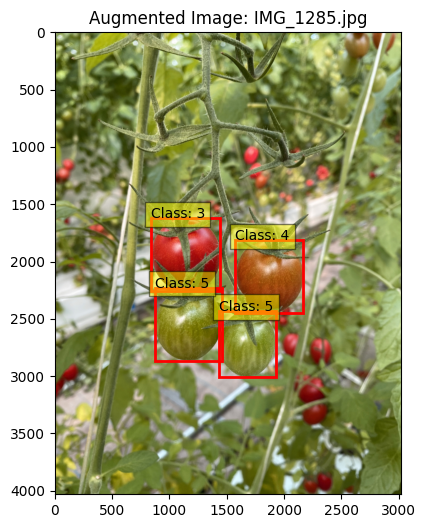

In [7]:
def check_random_augmented_image(image_folder, label_folder):
    """
    Selects a random augmented image, loads its bounding boxes, and visualizes it.
    """
    image_files = os.listdir(image_folder)
    if not image_files:
        print("No augmented images found!")
        return

    # Select a random image
    random_image = random.choice(image_files)
    img_path = os.path.join(image_folder, random_image)
    label_path = os.path.join(label_folder, os.path.splitext(random_image)[0] + ".txt")

    # Load the image
    image = cv2.imread(img_path)
    if image is None:
        print(f"Error loading image: {random_image}")
        return

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    h, w, _ = image.shape  # Get image dimensions

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(image)

    # Load bounding boxes and draw them
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f.readlines():
                cls, x_center, y_center, width, height = map(float, line.strip().split())

                # Convert YOLO format to pixel coordinates
                x_center *= w
                y_center *= h
                width *= w
                height *= h

                x_min = x_center - width / 2
                y_min = y_center - height / 2

                rect = plt.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                ax.text(x_min, y_min, f"Class: {int(cls)}", bbox=dict(facecolor='yellow', alpha=0.5))

    plt.title(f"Augmented Image: {random_image}")
    plt.show()

# Run the function to check a random augmented image
check_random_augmented_image(
    image_folder="/content/dataset_augmented/train/images",
    label_folder="/content/dataset_augmented/train/labels"
)


In [8]:
model = YOLO("yolov8n.pt")

model.train(
    data="/content/tomato_ripeness_classifier.yaml",
    epochs=20,
    batch=16,
    imgsz=640,
    project="/content/drive/MyDrive/tomato_ripeness_classifier/",
    name="yolov8_tomato_ripeness",
    workers=4,
    exist_ok=True
)


100%|██████████| 6.25M/6.25M [00:00<00:00, 75.1MB/s]


Ultralytics 8.3.75 🚀 Python-3.11.11 torch-2.5.1+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/tomato_ripeness_classifier.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=4, project=/content/drive/MyDrive/tomato_ripeness_classifier/, name=yolov8_tomato_ripeness, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_

100%|██████████| 755k/755k [00:00<00:00, 14.7MB/s]


Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/dataset_augmented/train/labels... 643 images, 0 backgrounds, 0 corrupt: 100%|██████████| 643/643 [00:00<00:00, 1623.90it/s]


train: New cache created: /content/dataset_augmented/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/dataset_augmented/val/labels... 161 images, 0 backgrounds, 0 corrupt: 100%|██████████| 161/161 [00:00<00:00, 1961.24it/s]

val: New cache created: /content/dataset_augmented/val/labels.cache


Plotting labels to /content/drive/MyDrive/tomato_ripeness_classifier/yolov8_tomato_ripeness/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to /content/drive/MyDrive/tomato_ripeness_classifier/yolov8_tomato_ripeness
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20         0G      1.134      3.145      1.126         71        640: 100%|██████████| 41/41 [11:39<00:00, 17.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [01:06<00:00, 11.04s/it]

                   all        161       1987      0.393      0.108      0.169      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20         0G       1.03      1.837       1.04         67        640: 100%|██████████| 41/41 [11:37<00:00, 17.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [01:07<00:00, 11.25s/it]

                   all        161       1987      0.411      0.444      0.368      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20         0G     0.9515      1.518      1.009         29        640: 100%|██████████| 41/41 [11:25<00:00, 16.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [01:10<00:00, 11.77s/it]

                   all        161       1987      0.401       0.42      0.346      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20         0G     0.9085      1.382      0.997         59        640: 100%|██████████| 41/41 [11:21<00:00, 16.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [01:05<00:00, 10.83s/it]

                   all        161       1987      0.492      0.523      0.454      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20         0G      0.869      1.316     0.9735         29        640: 100%|██████████| 41/41 [11:19<00:00, 16.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [01:20<00:00, 13.48s/it]

                   all        161       1987      0.518      0.595      0.565      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20         0G     0.8523      1.183     0.9631         54        640: 100%|██████████| 41/41 [11:24<00:00, 16.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [01:10<00:00, 11.70s/it]

                   all        161       1987      0.542      0.559      0.507      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20         0G     0.8175      1.164     0.9626         24        640: 100%|██████████| 41/41 [11:18<00:00, 16.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [01:09<00:00, 11.65s/it]

                   all        161       1987      0.521      0.567      0.511      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20         0G     0.8254      1.119     0.9539         45        640: 100%|██████████| 41/41 [11:27<00:00, 16.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [01:09<00:00, 11.62s/it]

                   all        161       1987      0.637      0.659      0.668      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20         0G     0.7898      1.061     0.9434         30        640: 100%|██████████| 41/41 [11:27<00:00, 16.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [01:17<00:00, 12.93s/it]

                   all        161       1987      0.661      0.691       0.69      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20         0G     0.7911      1.021     0.9415         99        640: 100%|██████████| 41/41 [11:22<00:00, 16.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [01:12<00:00, 12.09s/it]

                   all        161       1987      0.651      0.692      0.676      0.547


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20         0G     0.7391      1.044     0.9237         41        640: 100%|██████████| 41/41 [11:00<00:00, 16.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [01:10<00:00, 11.78s/it]

                   all        161       1987      0.661      0.667      0.672      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20         0G      0.729       1.02     0.9105         33        640: 100%|██████████| 41/41 [10:49<00:00, 15.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [01:11<00:00, 11.89s/it]

                   all        161       1987      0.697      0.697      0.713      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20         0G     0.7075     0.9568     0.9018         31        640: 100%|██████████| 41/41 [10:46<00:00, 15.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [01:11<00:00, 12.00s/it]

                   all        161       1987      0.677      0.702      0.716      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20         0G     0.7069      0.914     0.8989         79        640: 100%|██████████| 41/41 [10:53<00:00, 15.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [01:10<00:00, 11.81s/it]

                   all        161       1987      0.646      0.717        0.7      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20         0G     0.6915     0.8771     0.9015         33        640: 100%|██████████| 41/41 [11:01<00:00, 16.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [01:12<00:00, 12.02s/it]

                   all        161       1987      0.669      0.753      0.746      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20         0G     0.6806     0.8491     0.8916         23        640: 100%|██████████| 41/41 [10:37<00:00, 15.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [01:13<00:00, 12.22s/it]

                   all        161       1987      0.719      0.736      0.761      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20         0G     0.6607     0.8221     0.8885         23        640: 100%|██████████| 41/41 [11:03<00:00, 16.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [01:09<00:00, 11.51s/it]

                   all        161       1987      0.724      0.735      0.761       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20         0G     0.6543     0.8166      0.882         27        640: 100%|██████████| 41/41 [10:42<00:00, 15.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [01:06<00:00, 11.15s/it]

                   all        161       1987      0.746      0.702      0.766      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20         0G     0.6399     0.8024     0.8854         38        640: 100%|██████████| 41/41 [10:57<00:00, 16.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [01:10<00:00, 11.73s/it]

                   all        161       1987      0.721      0.772      0.781      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20         0G     0.6413     0.7789     0.8793         14        640: 100%|██████████| 41/41 [10:51<00:00, 15.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [01:08<00:00, 11.34s/it]

                   all        161       1987      0.707      0.764      0.779      0.646



20 epochs completed in 4.121 hours.
Optimizer stripped from /content/drive/MyDrive/tomato_ripeness_classifier/yolov8_tomato_ripeness/weights/last.pt, 6.2MB
Optimizer stripped from /content/drive/MyDrive/tomato_ripeness_classifier/yolov8_tomato_ripeness/weights/best.pt, 6.2MB

Validating /content/drive/MyDrive/tomato_ripeness_classifier/yolov8_tomato_ripeness/weights/best.pt...
Ultralytics 8.3.75 🚀 Python-3.11.11 torch-2.5.1+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:57<00:00,  9.62s/it]


                   all        161       1987      0.722      0.769      0.782      0.651
       b_fully_ripened         40         72      0.631      0.831      0.733      0.658
        b_half_ripened         52        114      0.654      0.711      0.698      0.592
               b_green         71        384      0.824      0.853       0.91      0.754
       l_fully_ripened         59        268      0.721      0.769      0.803      0.673
        l_half_ripened         67        223      0.701      0.695      0.727      0.606
               l_green         69        926        0.8      0.757      0.817      0.622
Speed: 2.0ms preprocess, 236.2ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to /content/drive/MyDrive/tomato_ripeness_classifier/yolov8_tomato_ripeness


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79d7a621e5d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
     

Ultralytics 8.3.75 🚀 Python-3.11.11 torch-2.5.1+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/dataset_augmented/val/labels.cache... 161 images, 0 backgrounds, 0 corrupt: 100%|██████████| 161/161 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:52<00:00,  4.77s/it]


                   all        161       1987      0.723      0.762       0.78      0.649
       b_fully_ripened         40         72      0.639      0.806      0.733      0.653
        b_half_ripened         52        114      0.646      0.693      0.688      0.589
               b_green         71        384      0.828      0.852      0.911      0.753
       l_fully_ripened         59        268      0.726      0.769      0.804      0.674
        l_half_ripened         67        223      0.702      0.695      0.727      0.606
               l_green         69        926        0.8      0.757      0.816      0.622
Speed: 1.5ms preprocess, 209.9ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs/detect/val2


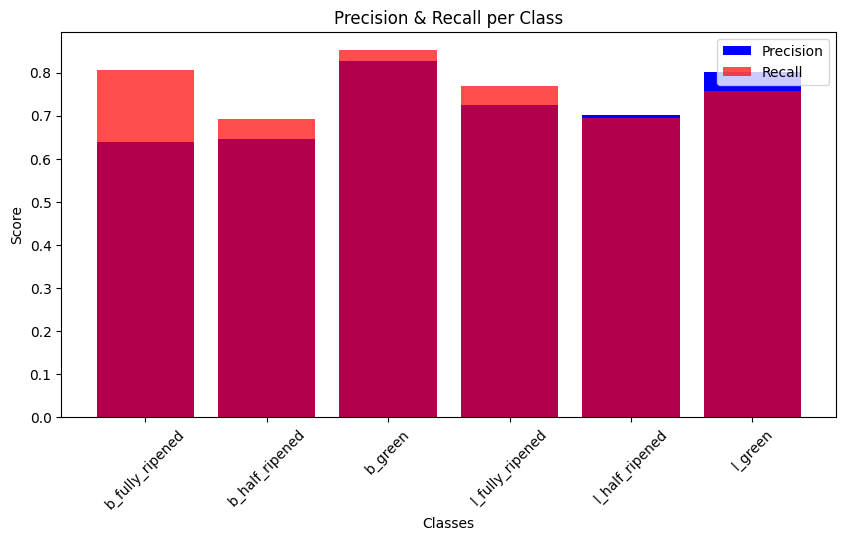

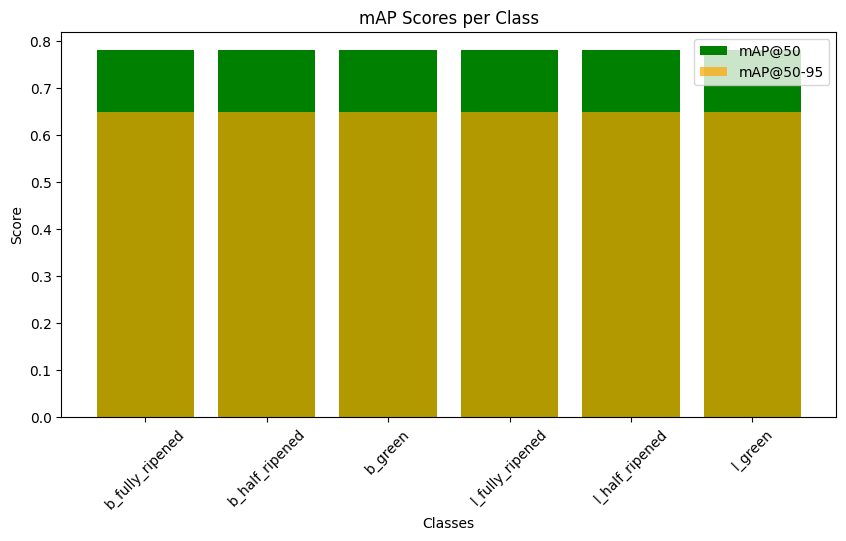

Evaluation Complete. Saved plots as images.


In [10]:
# Load the trained YOLOv8 model
model = YOLO("/content/drive/MyDrive/tomato_ripeness_classifier/yolov8_tomato_ripeness/weights/best.pt")

# Run evaluation on the validation set
metrics = model.val()

# Extract key metrics
precision = metrics.box.p  # Precision values per class
recall = metrics.box.r      # Recall values per class
map50 = metrics.box.map50  # mAP@50 values per class
map50_95 = metrics.box.map  # mAP@50-95 values per class
classes = metrics.names     # Class names


# Convert metrics to lists
class_labels = list(classes.values())  # Extract class names
num_classes = len(class_labels)

# Plot Precision & Recall
plt.figure(figsize=(10, 5))
plt.bar(class_labels, precision, color="blue", label="Precision")
plt.bar(class_labels, recall, color="red", alpha=0.7, label="Recall")
plt.xlabel("Classes")
plt.ylabel("Score")
plt.title("Precision & Recall per Class")
plt.legend()
plt.xticks(rotation=45)
plt.savefig("/content/precision_recall_plot.png")
plt.show()

# Plot mAP@50 and mAP@50-95
plt.figure(figsize=(10, 5))
plt.bar(class_labels, map50, color="green", label="mAP@50")
plt.bar(class_labels, map50_95, color="orange", alpha=0.7, label="mAP@50-95")
plt.xlabel("Classes")
plt.ylabel("Score")
plt.title("mAP Scores per Class")
plt.legend()
plt.xticks(rotation=45)
plt.savefig("/content/map_plot.png")
plt.show()

print("Evaluation Complete. Saved plots as images.")


In [13]:
model = YOLO("/content/drive/MyDrive/tomato_ripeness_classifier/yolov8_tomato_ripeness/weights/best.pt")

test_image_folder = "/content/dataset_augmented/val/images"
image_files = os.listdir(test_image_folder)

if not image_files:
    print("No images found in the validation set!")
else:
    random_image = random.choice(image_files)
    image_path = os.path.join(test_image_folder, random_image)

    results = model(image_path, conf=0.5)

    # Access the first (and likely only) Results object in the list
    results = results[0] # Access the first element (Results object)

    results.show()

    output_image_path = f"/content/{random_image}_pred.jpg"
    results.save(filename=output_image_path)

    print(f"Inference complete. Saved result to {output_image_path}.")


image 1/1 /content/dataset_augmented/val/images/IMG_20191215_112526.jpg: 640x480 2 l_fully_ripeneds, 6 l_greens, 941.7ms
Speed: 27.0ms preprocess, 941.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)
